# Train and test forecast models

## Neural-Prophet

In [1]:
from neuralprophet import NeuralProphet
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import logging

# Desactiva los warnings y ajusta el logging de NeuralProphet
warnings.filterwarnings("ignore")
logging.getLogger("NP").setLevel(logging.ERROR)

/home/consumo_agua/miniconda3/envs/neural-prophet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Cargamos los datos, utilizaremos el cluster 1 para los experimentos:

In [2]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('predictions_dia_avg/predictions_1_filtrado.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

df = df.rename(columns={'day': 'ds', 'avg_all_users': 'y'})

# Aseguramos que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Eliminamos la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df.head()

datetime64[ns]


,ds,y
0,2018-11-13,0.006500
1,2018-11-14,0.004318
2,2018-11-15,0.000000
3,2018-11-16,0.004091
4,2018-11-17,0.002500


Graficamos el dataset, mostrando el valor (colmuna Y) a través del tiempo (columna ds)

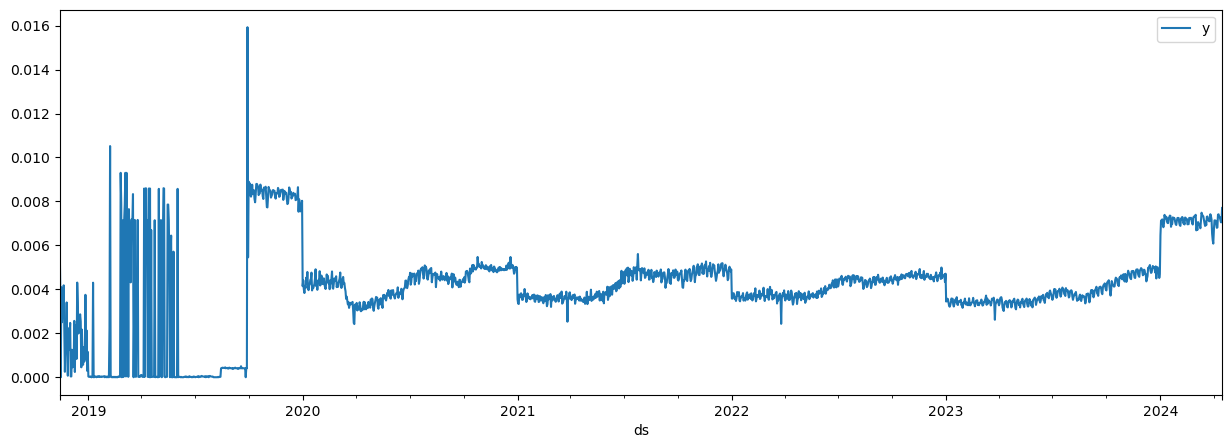

In [3]:
plt = df.plot(x="ds", y="y", figsize=(15, 5))

#### Explicación de las Métricas a Calcular
- MAE (Error Absoluto Medio): mide el error promedio en las predicciones, sin tener en cuenta la dirección del error.
- RMSE (Raíz del Error Cuadrático Medio): pondera los errores grandes más que los pequeños, siendo más sensible a valores atípicos.
- MAPE (Error Absoluto Medio Porcentual): mide el error en porcentaje, lo que lo hace independiente de la escala de los datos.

Eventos y festividades de la provincia de Castellón:

In [5]:
# Definimos las fechas de las festividades (ejemplo, deben ser ajustadas con las fechas precisas)
festividades = {
    "event": ["fiestas_magdalena", "san_juan", "fiestas_patronales"] * 7,
    "ds": pd.to_datetime([
        # Fiestas de La Magdalena
        "2018-03-11", "2019-03-24", "2020-03-15", "2021-03-07", "2022-03-20", "2023-03-12", "2024-03-03",
        # San Juan
        "2018-06-24", "2019-06-24", "2020-06-24", "2021-06-24", "2022-06-24", "2023-06-24", "2024-06-24",
        # Fiestas Patronales (ej. Virgen de la Misericordia)
        "2018-09-08", "2019-09-08", "2020-09-08", "2021-09-08", "2022-09-08", "2023-09-08", "2024-09-08",
    ])
}

# Crear el DataFrame
df_events = pd.DataFrame(festividades)
# df_events

Definimos la longitud de las ventanas deslizantes de train y test

In [6]:
train_size = 365   # Ventana de train de 1 año
test_size = 30     # Ventana de test de 1 mes

In [5]:
# Lista para guardar los resultados de cada ventana
results = []

# Realizar el proceso de la ventana deslizante
for start in range(0, len(df) - train_size - test_size + 1, test_size):
    # Define el conjunto de entrenamiento y prueba en cada iteración
    train_df = df.iloc[start:start + train_size]
    test_df = df.iloc[start + train_size:start + train_size + test_size]
    
    # Inicializa el modelo de NeuralProphet
    model = NeuralProphet()
    
    # Ajusta el modelo usando la ventana de entrenamiento
    model.fit(train_df, freq="D")
    
    # Realiza la predicción sobre el conjunto de prueba
    future = model.make_future_dataframe(train_df, periods=test_size, n_historic_predictions=len(train_df))
    forecast = model.predict(future)
    
    # Extrae solo las predicciones para el período de prueba
    forecast_test = forecast.iloc[-test_size:][["ds", "yhat1"]]
    forecast_test["y_true"] = test_df["y"].values  # Añade los valores reales de prueba
    
    # Calcular MAE, RMSE y MAPE para esta ventana y almacenar los resultados
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat1"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat1"]))
    mape = mean_absolute_percentage_error(forecast_test["y_true"], forecast_test["yhat1"]) * 100
    
    # Almacena los resultados en la lista
    results.append({
        "start_date": train_df["ds"].iloc[0], 
        "end_date": test_df["ds"].iloc[-1], 
        "MAE": mae, 
        "RMSE": rmse,
        "MAPE": mape
    })


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 206.15it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=77, train_loss=0.0787, reg_loss=0.000, MAE=0.00175, RMSE=0.00245, Loss=0.0789, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 494.96it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 210.39it/s]


Training: |          | 0/? [00:19<?, ?it/s, v_num=78, train_loss=0.0761, reg_loss=0.000, MAE=0.00166, RMSE=0.00239, Loss=0.076, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 294.77it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 166.62it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=79, train_loss=0.0635, reg_loss=0.000, MAE=0.00152, RMSE=0.0023, Loss=0.0634, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 340.12it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 173.53it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=80, train_loss=0.0533, reg_loss=0.000, MAE=0.00145, RMSE=0.00218, Loss=0.0534, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 479.95it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 756.77it/s]  

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 205.93it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=81, train_loss=0.0449, reg_loss=0.000, MAE=0.00129, RMSE=0.00196, Loss=0.0449, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 462.44it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 214.09it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=82, train_loss=0.0284, reg_loss=0.000, MAE=0.000884, RMSE=0.00153, Loss=0.0282, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.21it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 158.12it/s]


Training: |          | 0/? [00:20<?, ?it/s, v_num=83, train_loss=0.0193, reg_loss=0.000, MAE=0.000706, RMSE=0.00122, Loss=0.0198, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 380.61it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 153.06it/s]


Training: |          | 0/? [00:16<?, ?it/s, v_num=84, train_loss=0.0125, reg_loss=0.000, MAE=0.000543, RMSE=0.000898, Loss=0.0124, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 1172.33it/s]  
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.17it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=85, train_loss=0.0132, reg_loss=0.000, MAE=0.000545, RMSE=0.000972, Loss=0.0131, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.34it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 603.12it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 168.35it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=86, train_loss=0.00999, reg_loss=0.000, MAE=0.000478, RMSE=0.000868, Loss=0.010, RegLoss=0.000]  
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.72it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 224.25it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=87, train_loss=0.0139, reg_loss=0.000, MAE=0.000602, RMSE=0.0011, Loss=0.0139, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 355.33it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 212.72it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=88, train_loss=0.00502, reg_loss=0.000, MAE=0.000265, RMSE=0.000403, Loss=0.00501, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 914.30it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 209.94it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=89, train_loss=0.00638, reg_loss=0.000, MAE=0.000302, RMSE=0.000446, Loss=0.00635, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 347.41it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 162.39it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=90, train_loss=0.00622, reg_loss=0.000, MAE=0.000279, RMSE=0.000437, Loss=0.00628, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.35it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 162.61it/s]


Training: |          | 0/? [00:20<?, ?it/s, v_num=91, train_loss=0.0128, reg_loss=0.000, MAE=0.00018, RMSE=0.000246, Loss=0.0128, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 863.12it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 199.43it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=92, train_loss=0.0147, reg_loss=0.000, MAE=0.000214, RMSE=0.000272, Loss=0.0146, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 504.43it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 197.89it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=93, train_loss=0.0127, reg_loss=0.000, MAE=0.000188, RMSE=0.000248, Loss=0.0128, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 401.83it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 149.28it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=94, train_loss=0.0145, reg_loss=0.000, MAE=0.000192, RMSE=0.000251, Loss=0.0145, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 710.35it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 162.20it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=95, train_loss=0.00923, reg_loss=0.000, MAE=0.000158, RMSE=0.000206, Loss=0.00919, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 324.89it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 608.00it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 178.08it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=96, train_loss=0.00868, reg_loss=0.000, MAE=0.000155, RMSE=0.000203, Loss=0.00864, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 435.27it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 202.42it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=97, train_loss=0.00964, reg_loss=0.000, MAE=0.000166, RMSE=0.000214, Loss=0.00968, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 492.29it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 200.04it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=98, train_loss=0.00859, reg_loss=0.000, MAE=0.000155, RMSE=0.000207, Loss=0.0086, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 663.51it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 160.55it/s]


Training: |          | 0/? [00:23<?, ?it/s, v_num=99, train_loss=0.0108, reg_loss=0.000, MAE=0.000174, RMSE=0.000231, Loss=0.0108, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.37it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 164.40it/s]


Training: |          | 0/? [00:19<?, ?it/s, v_num=100, train_loss=0.00882, reg_loss=0.000, MAE=0.000159, RMSE=0.000212, Loss=0.00882, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 479.18it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 205.81it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=101, train_loss=0.00794, reg_loss=0.000, MAE=0.000147, RMSE=0.0002, Loss=0.00796, RegLoss=0.000]  
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 839.84it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 198.42it/s]


Training: |          | 0/? [00:19<?, ?it/s, v_num=102, train_loss=0.00855, reg_loss=0.000, MAE=0.000159, RMSE=0.000216, Loss=0.00855, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.99it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 153.60it/s]


Training: |          | 0/? [00:23<?, ?it/s, v_num=103, train_loss=0.00578, reg_loss=0.000, MAE=0.000127, RMSE=0.000163, Loss=0.00575, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 280.20it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 155.87it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=104, train_loss=0.0155, reg_loss=0.000, MAE=0.000195, RMSE=0.000252, Loss=0.0154, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 707.25it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 193.42it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=105, train_loss=0.0117, reg_loss=0.000, MAE=0.000169, RMSE=0.000223, Loss=0.0117, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 455.80it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 689.68it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 202.97it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=106, train_loss=0.0131, reg_loss=0.000, MAE=0.000188, RMSE=0.000244, Loss=0.013, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 559.17it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 283.41it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=107, train_loss=0.00732, reg_loss=0.000, MAE=0.000142, RMSE=0.000187, Loss=0.00731, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.52it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 149.05it/s]


Training: |          | 0/? [00:23<?, ?it/s, v_num=108, train_loss=0.00722, reg_loss=0.000, MAE=0.000141, RMSE=0.000189, Loss=0.0072, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 671.90it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 179.15it/s]


Training: |          | 0/? [00:19<?, ?it/s, v_num=109, train_loss=0.00741, reg_loss=0.000, MAE=0.000147, RMSE=0.000192, Loss=0.00741, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 839.29it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 211.69it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=110, train_loss=0.00598, reg_loss=0.000, MAE=0.000133, RMSE=0.000171, Loss=0.00595, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 540.36it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 208.20it/s]


Training: |          | 0/? [00:19<?, ?it/s, v_num=111, train_loss=0.00653, reg_loss=0.000, MAE=0.000142, RMSE=0.000183, Loss=0.00652, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 363.62it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 158.78it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=112, train_loss=0.0047, reg_loss=0.000, MAE=0.000118, RMSE=0.000161, Loss=0.00469, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.90it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 164.42it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=113, train_loss=0.00456, reg_loss=0.000, MAE=0.000116, RMSE=0.000161, Loss=0.00455, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 913.64it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 206.80it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=114, train_loss=0.00498, reg_loss=0.000, MAE=0.000113, RMSE=0.000163, Loss=0.00499, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 439.06it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 207.88it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=115, train_loss=0.00596, reg_loss=0.000, MAE=0.000103, RMSE=0.000159, Loss=0.00592, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 383.22it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 166.05it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=116, train_loss=0.0139, reg_loss=0.000, MAE=0.000149, RMSE=0.00021, Loss=0.0139, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 706.83it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 162.83it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=117, train_loss=0.0106, reg_loss=0.000, MAE=0.000131, RMSE=0.000185, Loss=0.0106, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 377.90it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 596.19it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 178.70it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=118, train_loss=0.0162, reg_loss=0.000, MAE=0.00015, RMSE=0.000207, Loss=0.0162, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 458.09it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 206.62it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=119, train_loss=0.00681, reg_loss=0.000, MAE=9.57e-5, RMSE=0.000136, Loss=0.00677, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.68it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 208.62it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=120, train_loss=0.00657, reg_loss=0.000, MAE=9.77e-5, RMSE=0.000136, Loss=0.00657, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 686.03it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 160.30it/s]


Training: |          | 0/? [00:23<?, ?it/s, v_num=121, train_loss=0.00739, reg_loss=0.000, MAE=0.000105, RMSE=0.000148, Loss=0.00735, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.29it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 153.08it/s]


Training: |          | 0/? [00:17<?, ?it/s, v_num=122, train_loss=0.00728, reg_loss=0.000, MAE=0.000106, RMSE=0.000152, Loss=0.00732, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 457.94it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 208.45it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=123, train_loss=0.00788, reg_loss=0.000, MAE=0.000115, RMSE=0.000164, Loss=0.0079, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 871.10it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 209.01it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=124, train_loss=0.00712, reg_loss=0.000, MAE=0.000112, RMSE=0.000154, Loss=0.0071, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 277.20it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 145.82it/s]


Training: |          | 0/? [00:23<?, ?it/s, v_num=125, train_loss=0.00833, reg_loss=0.000, MAE=0.000125, RMSE=0.00017, Loss=0.00829, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 339.54it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 153.21it/s]


Training: |          | 0/? [00:20<?, ?it/s, v_num=126, train_loss=0.00463, reg_loss=0.000, MAE=8.86e-5, RMSE=0.000131, Loss=0.00471, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 836.06it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 206.00it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=127, train_loss=0.00424, reg_loss=0.000, MAE=8.93e-5, RMSE=0.000136, Loss=0.00424, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.38it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 726.44it/s]   

Finding best initial lr: 100%|██████████| 216/216 [00:01<00:00, 206.49it/s]


Training: |          | 0/? [00:15<?, ?it/s, v_num=128, train_loss=0.0105, reg_loss=0.000, MAE=0.0002, RMSE=0.000321, Loss=0.0105, RegLoss=0.000]  
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 644.78it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 263.86it/s]


Training: |          | 0/? [00:21<?, ?it/s, v_num=129, train_loss=0.00718, reg_loss=0.000, MAE=0.000187, RMSE=0.000293, Loss=0.00713, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.27it/s]


In [ ]:
results_df = pd.DataFrame(results)
results_df

,start_date,end_date,MAE,RMSE,MAPE
0,2018-11-13,2019-12-12,0.003096,0.003258,37.187990
1,2018-12-13,2020-01-11,0.005653,0.006231,108.058339
2,2019-01-12,2020-02-10,0.002843,0.002856,66.316105
3,2019-02-11,2020-03-11,0.001521,0.001605,34.960510
4,2019-03-13,2020-04-10,0.001025,0.001088,30.983291
5,2019-04-12,2020-05-10,0.000619,0.000689,18.445141
6,2019-05-12,2020-06-09,0.000825,0.000862,22.228182
7,2019-06-11,2020-07-09,0.000854,0.000922,19.902402
8,2019-07-11,2020-08-08,0.000196,0.000234,4.083732
9,2019-08-10,2020-09-07,0.000652,0.000697,14.503334


In [7]:
# Calcula el promedio de cada métrica
mean_mae = results_df["MAE"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_mape = results_df["MAPE"].mean()

mean_metrics = pd.DataFrame({
    "MAE": [mean_mae],
    "RMSE": [mean_rmse],
    "MAPE (%)": [mean_mape]
})

mean_metrics

,MAE,RMSE,MAPE (%)
0,0.000676,0.000734,15.029194


Añadimos festividades y parámetros al modelo:

In [11]:
# Lista para guardar los resultados de cada ventana
results_v2 = []

# Realizar el proceso de la ventana deslizante
for start in range(0, len(df) - train_size - test_size + 1, test_size):
    # Define el conjunto de entrenamiento y prueba en cada iteración
    train_df = df.iloc[start:start + train_size]
    test_df = df.iloc[start + train_size:start + train_size + test_size]
    
    model = NeuralProphet(
    n_lags=30,             # Captura dependencias de 30 días anteriores
    # n_forecasts=30,        # Predicción de 30 días hacia adelante
    yearly_seasonality=True,  # Estacionalidad anual
    weekly_seasonality=True,  # Estacionalidad semanal
    daily_seasonality=False   # Desactivar estacionalidad diaria si no es relevante
)
    # Añadimos festividades nacionales
    model.add_country_holidays(country_name="ES")
    # model = model.add_events(["fiestas_magdalena", "san_juan", "fiestas_patronales"])
    # Entrenar el modelo incluyendo los eventos
    # model.fit(df, freq="D", events_df=df_events)

    # Ajusta el modelo usando la ventana de entrenamiento
    model.fit(train_df, freq="D")
    
    # Realiza la predicción sobre el conjunto de prueba
    future = model.make_future_dataframe(train_df, periods=test_size, n_historic_predictions=len(train_df))
    forecast = model.predict(future)
    
    # Extrae solo las predicciones para el período de prueba
    forecast_test = forecast.iloc[-test_size:][["ds", "yhat1"]]
    forecast_test["y_true"] = test_df["y"].values  # Añade los valores reales de prueba
    
    # Calcular MAE, RMSE y MAPE para esta ventana y almacenar los resultados
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat1"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat1"]))
    mape = mean_absolute_percentage_error(forecast_test["y_true"], forecast_test["yhat1"]) * 100
    
    # Almacena los resultados en la lista
    results_v2.append({
        "start_date": train_df["ds"].iloc[0], 
        "end_date": test_df["ds"].iloc[-1], 
        "MAE": mae, 
        "RMSE": rmse,
        "MAPE": mape
    })

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 269.34it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=132, train_loss=0.0557, reg_loss=0.000, MAE=0.00131, RMSE=0.00212, Loss=0.0557, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 920.19it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.27it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=133, train_loss=0.0441, reg_loss=0.000, MAE=0.00115, RMSE=0.00188, Loss=0.0445, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 863.56it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 273.70it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=134, train_loss=0.0389, reg_loss=0.000, MAE=0.00108, RMSE=0.00184, Loss=0.039, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 930.59it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 270.67it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=135, train_loss=0.0288, reg_loss=0.000, MAE=0.000892, RMSE=0.00156, Loss=0.0289, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 984.82it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 272.13it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=136, train_loss=0.0222, reg_loss=0.000, MAE=0.00072, RMSE=0.00134, Loss=0.0221, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 371.51it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.91it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=137, train_loss=0.0118, reg_loss=0.000, MAE=0.000495, RMSE=0.000886, Loss=0.0118, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 366.12it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 276.95it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=138, train_loss=0.00439, reg_loss=0.000, MAE=0.000206, RMSE=0.000409, Loss=0.00438, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 313.73it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 271.66it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=139, train_loss=0.0125, reg_loss=0.000, MAE=0.000442, RMSE=0.000872, Loss=0.0125, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.80it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 277.51it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=140, train_loss=0.00488, reg_loss=0.000, MAE=0.000268, RMSE=0.00051, Loss=0.00487, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 357.97it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 272.95it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=141, train_loss=0.0164, reg_loss=0.000, MAE=0.000624, RMSE=0.00114, Loss=0.0164, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 928.73it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.37it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=142, train_loss=0.00241, reg_loss=0.000, MAE=0.000235, RMSE=0.000365, Loss=0.00241, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 935.22it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 273.54it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=143, train_loss=0.00188, reg_loss=0.000, MAE=0.00018, RMSE=0.000231, Loss=0.00188, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 965.22it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 281.38it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=144, train_loss=0.00183, reg_loss=0.000, MAE=0.000177, RMSE=0.000232, Loss=0.00183, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.39it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.69it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=145, train_loss=0.00303, reg_loss=0.000, MAE=0.000216, RMSE=0.000283, Loss=0.00302, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 368.34it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 276.32it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=146, train_loss=0.0115, reg_loss=0.000, MAE=0.000206, RMSE=0.000251, Loss=0.0115, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.85it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.32it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=147, train_loss=0.00555, reg_loss=0.000, MAE=0.000134, RMSE=0.000168, Loss=0.00558, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 323.04it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 276.70it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=148, train_loss=0.00423, reg_loss=0.000, MAE=0.000118, RMSE=0.000149, Loss=0.00424, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 281.03it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.37it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=149, train_loss=0.0123, reg_loss=0.000, MAE=0.000188, RMSE=0.000239, Loss=0.0123, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 920.69it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 276.09it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=150, train_loss=0.00551, reg_loss=0.000, MAE=0.000121, RMSE=0.000154, Loss=0.0055, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 936.50it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 273.10it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=151, train_loss=0.00524, reg_loss=0.000, MAE=0.000119, RMSE=0.000156, Loss=0.00527, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 994.06it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.31it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=152, train_loss=0.0122, reg_loss=0.000, MAE=0.000188, RMSE=0.000241, Loss=0.0122, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.08it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 277.30it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=153, train_loss=0.00544, reg_loss=0.000, MAE=0.000121, RMSE=0.00016, Loss=0.00543, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 281.01it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 280.12it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=154, train_loss=0.00475, reg_loss=0.000, MAE=0.000114, RMSE=0.000151, Loss=0.00474, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 347.30it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.39it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=155, train_loss=0.0122, reg_loss=0.000, MAE=0.000183, RMSE=0.00025, Loss=0.0122, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.88it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 277.71it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=156, train_loss=0.0103, reg_loss=0.000, MAE=0.000178, RMSE=0.000231, Loss=0.0103, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 392.91it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.53it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=157, train_loss=0.00483, reg_loss=0.000, MAE=0.000122, RMSE=0.000155, Loss=0.00483, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.99it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.46it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=158, train_loss=0.010, reg_loss=0.000, MAE=0.00017, RMSE=0.000215, Loss=0.00999, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 993.29it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.04it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=159, train_loss=0.00433, reg_loss=0.000, MAE=0.00011, RMSE=0.000144, Loss=0.00433, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 380.26it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.73it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=160, train_loss=0.00386, reg_loss=0.000, MAE=0.000106, RMSE=0.000136, Loss=0.00386, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 377.25it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 272.40it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=161, train_loss=0.00532, reg_loss=0.000, MAE=0.000121, RMSE=0.000158, Loss=0.00531, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.95it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.26it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=162, train_loss=0.00401, reg_loss=0.000, MAE=0.000105, RMSE=0.000136, Loss=0.004, RegLoss=0.000]  
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 371.05it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.07it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=163, train_loss=0.00399, reg_loss=0.000, MAE=0.000103, RMSE=0.000137, Loss=0.00399, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 372.86it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.54it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=164, train_loss=0.00537, reg_loss=0.000, MAE=0.000124, RMSE=0.000162, Loss=0.00536, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 964.58it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 279.67it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=165, train_loss=0.00416, reg_loss=0.000, MAE=0.000109, RMSE=0.000142, Loss=0.00418, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 1006.32it/s]  
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 280.11it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=166, train_loss=0.00425, reg_loss=0.000, MAE=0.000111, RMSE=0.000146, Loss=0.00425, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.21it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 280.76it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=167, train_loss=0.0037, reg_loss=0.000, MAE=0.000104, RMSE=0.000136, Loss=0.00369, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.16it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.71it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=168, train_loss=0.00309, reg_loss=0.000, MAE=9.51e-5, RMSE=0.000126, Loss=0.00309, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 292.86it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.18it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=169, train_loss=0.00874, reg_loss=0.000, MAE=0.000154, RMSE=0.000208, Loss=0.00873, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 377.39it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 272.76it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=170, train_loss=0.00318, reg_loss=0.000, MAE=8.27e-5, RMSE=0.000112, Loss=0.00318, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 379.23it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.20it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=171, train_loss=0.0073, reg_loss=0.000, MAE=0.000123, RMSE=0.000167, Loss=0.00729, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 356.84it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 273.25it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=172, train_loss=0.00426, reg_loss=0.000, MAE=9.22e-5, RMSE=0.000122, Loss=0.00426, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 955.01it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.63it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=173, train_loss=0.00567, reg_loss=0.000, MAE=9.39e-5, RMSE=0.000126, Loss=0.00571, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 320.94it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 279.23it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=174, train_loss=0.0069, reg_loss=0.000, MAE=0.000104, RMSE=0.000143, Loss=0.00689, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 388.04it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.17it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=175, train_loss=0.00456, reg_loss=0.000, MAE=8.27e-5, RMSE=0.000115, Loss=0.00455, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 393.61it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 274.80it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=176, train_loss=0.0106, reg_loss=0.000, MAE=0.000125, RMSE=0.00018, Loss=0.0106, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 372.26it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 279.50it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=177, train_loss=0.00404, reg_loss=0.000, MAE=8.05e-5, RMSE=0.000113, Loss=0.00404, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 405.76it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 277.52it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=178, train_loss=0.00354, reg_loss=0.000, MAE=7.48e-5, RMSE=0.000107, Loss=0.00353, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 887.29it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.13it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=179, train_loss=0.00638, reg_loss=0.000, MAE=0.000108, RMSE=0.000147, Loss=0.00636, RegLoss=0.000]
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 996.72it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.15it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=180, train_loss=0.00351, reg_loss=0.000, MAE=7.66e-5, RMSE=0.000108, Loss=0.00351, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.32it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.33it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=181, train_loss=0.00254, reg_loss=0.000, MAE=6.88e-5, RMSE=9.23e-5, Loss=0.00253, RegLoss=0.000]  
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.14it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 275.16it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=182, train_loss=0.00169, reg_loss=0.000, MAE=5.9e-5, RMSE=7.97e-5, Loss=0.00169, RegLoss=0.000]   
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 371.97it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 278.92it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=183, train_loss=0.00153, reg_loss=0.000, MAE=9.14e-5, RMSE=0.000127, Loss=0.00153, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 369.80it/s]
Training: |          | 0/? [00:00<?, ?it/s]

Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 451.78it/s]   


Finding best initial lr: 100%|██████████| 216/216 [00:00<00:00, 222.86it/s]


Training: |          | 0/? [00:12<?, ?it/s, v_num=184, train_loss=0.00465, reg_loss=0.000, MAE=0.000169, RMSE=0.00024, Loss=0.00464, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.53it/s]


In [12]:
# Convierte los resultados en un DataFrame para analizarlos
results_df_v2 = pd.DataFrame(results_v2)

# Calcula el promedio de cada métrica
mean_mae = results_df_v2["MAE"].mean()
mean_rmse = results_df_v2["RMSE"].mean()
mean_mape = results_df_v2["MAPE"].mean()

mean_metrics_v2 = pd.DataFrame({
    "MAE": [mean_mae],
    "RMSE": [mean_rmse],
    "MAPE (%)": [mean_mape]
})

mean_metrics_v2

,MAE,RMSE,MAPE (%)
0,0.000438,0.000537,10.240162


In [13]:
# Lista para guardar los resultados de cada ventana
results_v3 = []

# Realizar el proceso de la ventana deslizante
for start in range(0, len(df) - train_size - test_size + 1, test_size):
    # Define el conjunto de entrenamiento y prueba en cada iteración
    train_df = df.iloc[start:start + train_size]
    test_df = df.iloc[start + train_size:start + train_size + test_size]
    
    model = NeuralProphet(
    n_lags=30,             # Captura dependencias de 30 días anteriores
    # n_forecasts=30,        # Predicción de 30 días hacia adelante
    yearly_seasonality=True,  # Estacionalidad anual
    weekly_seasonality=True,  # Estacionalidad semanal
    daily_seasonality=False,   # Desactivar estacionalidad diaria si no es relevante
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
    growth="off",
)
    
    # Añadimos festividades nacionales
    model.add_country_holidays(country_name="ES")
    # model = model.add_events(["fiestas_magdalena", "san_juan", "fiestas_patronales"])
    # Entrenar el modelo incluyendo los eventos
    # model.fit(df, freq="D", events_df=df_events)

    # Ajusta el modelo usando la ventana de entrenamiento
    model.fit(train_df, freq="D")
    
    # Realiza la predicción sobre el conjunto de prueba
    future = model.make_future_dataframe(train_df, periods=test_size, n_historic_predictions=len(train_df))
    forecast = model.predict(future)
    
    # Extrae solo las predicciones para el período de prueba
    forecast_test = forecast.iloc[-test_size:][["ds", "yhat1"]]
    forecast_test["y_true"] = test_df["y"].values  # Añade los valores reales de prueba
    
    # Calcular MAE, RMSE y MAPE para esta ventana y almacenar los resultados
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat1"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat1"]))
    mape = mean_absolute_percentage_error(forecast_test["y_true"], forecast_test["yhat1"]) * 100
    
    # Almacena los resultados en la lista
    results_v3.append({
        "start_date": train_df["ds"].iloc[0], 
        "end_date": test_df["ds"].iloc[-1], 
        "MAE": mae, 
        "RMSE": rmse,
        "MAPE": mape
    })

Training: |          | 0/? [00:13<?, ?it/s, v_num=185, train_loss=0.000846, reg_loss=0.000, MAE=8.45e-5, RMSE=0.00016, Loss=0.000844, RegLoss=0.000] 
Epoch 160: 100%|██████████| 160/160 [00:00<00:00, 978.04it/s]   
Training: |          | 0/? [00:13<?, ?it/s, v_num=186, train_loss=0.00322, reg_loss=0.000, MAE=0.000107, RMSE=0.000228, Loss=0.00321, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 363.27it/s]
Training: |          | 0/? [00:13<?, ?it/s, v_num=187, train_loss=0.00112, reg_loss=0.000, MAE=0.000125, RMSE=0.00021, Loss=0.00112, RegLoss=0.000] 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 406.86it/s]
Training: |          | 0/? [00:13<?, ?it/s, v_num=188, train_loss=0.00496, reg_loss=0.000, MAE=0.000188, RMSE=0.000396, Loss=0.00495, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 369.57it/s]
Training: |          | 0/? [00:13<?, ?it/s, v_num=189, train_loss=0.00383, reg_loss=0.000, MAE=0.000149, RMSE=0.000319, Lo

In [14]:
# Convierte los resultados en un DataFrame para analizarlos
results_df_v3 = pd.DataFrame(results_v3)

# Calcula el promedio de cada métrica
mean_mae = results_df_v3["MAE"].mean()
mean_rmse = results_df_v3["RMSE"].mean()
mean_mape = results_df_v3["MAPE"].mean()

mean_metrics_v3 = pd.DataFrame({
    "MAE": [mean_mae],
    "RMSE": [mean_rmse],
    "MAPE (%)": [mean_mape]
})

mean_metrics_v3

,MAE,RMSE,MAPE (%)
0,0.000427,0.000525,10.059079


In [8]:
# Lista para guardar los resultados de cada ventana
results_v4 = []

# Realizar el proceso de la ventana deslizante
for start in range(0, len(df) - train_size - test_size + 1, test_size):
    # Define el conjunto de entrenamiento y prueba en cada iteración
    train_df = df.iloc[start:start + train_size]
    test_df = df.iloc[start + train_size:start + train_size + test_size]
    
    model = NeuralProphet(
        growth="off",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=True,
        n_lags=3 * 24,
        learning_rate=0.01,
        ar_reg=1,
    )
    
    # Añadimos festividades nacionales
    model.add_country_holidays(country_name="ES")
    # model = model.add_events(["fiestas_magdalena", "san_juan", "fiestas_patronales"])
    # Entrenar el modelo incluyendo los eventos
    # model.fit(df, freq="D", events_df=df_events)

    # Ajusta el modelo usando la ventana de entrenamiento
    model.fit(train_df, freq="D")
    
    # Realiza la predicción sobre el conjunto de prueba
    future = model.make_future_dataframe(train_df, periods=test_size, n_historic_predictions=len(train_df))
    forecast = model.predict(future)
    
    # Extrae solo las predicciones para el período de prueba
    forecast_test = forecast.iloc[-test_size:][["ds", "yhat1"]]
    forecast_test["y_true"] = test_df["y"].values  # Añade los valores reales de prueba
    
    # Calcular MAE, RMSE y MAPE para esta ventana y almacenar los resultados
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat1"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat1"]))
    mape = mean_absolute_percentage_error(forecast_test["y_true"], forecast_test["yhat1"]) * 100
    
    # Almacena los resultados en la lista
    results_v4.append({
        "start_date": train_df["ds"].iloc[0], 
        "end_date": test_df["ds"].iloc[-1], 
        "MAE": mae, 
        "RMSE": rmse,
        "MAPE": mape
    })

Epoch 1:   1%|          | 1/170 [00:00<00:00, 1660.45it/s]

Training: |          | 0/? [00:10<?, ?it/s, v_num=238, train_loss=0.0535, reg_loss=0.00242, MAE=0.00132, RMSE=0.00205, Loss=0.0562, RegLoss=0.00242]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.57it/s]
Training: |          | 0/? [00:10<?, ?it/s, v_num=239, train_loss=0.0496, reg_loss=0.00206, MAE=0.00116, RMSE=0.00186, Loss=0.0479, RegLoss=0.00206]
Epoch 170: 100%|██████████| 170/170 [00:00<00:00, 1005.27it/s]  
Training: |          | 0/? [00:10<?, ?it/s, v_num=240, train_loss=0.0327, reg_loss=0.00229, MAE=0.0009, RMSE=0.00149, Loss=0.0323, RegLoss=0.00229]  
Epoch 170: 100%|██████████| 170/170 [00:00<00:00, 978.71it/s]   
Training: |          | 0/? [00:10<?, ?it/s, v_num=241, train_loss=0.0218, reg_loss=0.00202, MAE=0.000654, RMSE=0.00111, Loss=0.0213, RegLoss=0.00202]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 444.36it/s]
Training: |          | 0/? [00:10<?, ?it/s, v_num=242, train_loss=0.00999, reg_loss=0.00177, MAE=0.000329, RMSE=0.000615, Loss=0

In [10]:
# Convierte los resultados en un DataFrame para analizarlos
results_df_v4 = pd.DataFrame(results_v4)

# Calcula el promedio de cada métrica
mean_mae = results_df_v4["MAE"].mean()
mean_rmse = results_df_v4["RMSE"].mean()
mean_mape = results_df_v4["MAPE"].mean()

mean_metrics_v4 = pd.DataFrame({
    "MAE": [mean_mae],
    "RMSE": [mean_rmse],
    "MAPE (%)": [mean_mape]
})

mean_metrics_v4

,MAE,RMSE,MAPE (%)
0,0.000451,0.000545,10.535414
